In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])

,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


In [3]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

In [4]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 1024
HIDDEN_LAYER_DIM2 = 512
HIDDEN_LAYER_DIM3 = 256
OUTPUT_CLASSES = 2

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM2, activation='sigmoid'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM3, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [8]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [11]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

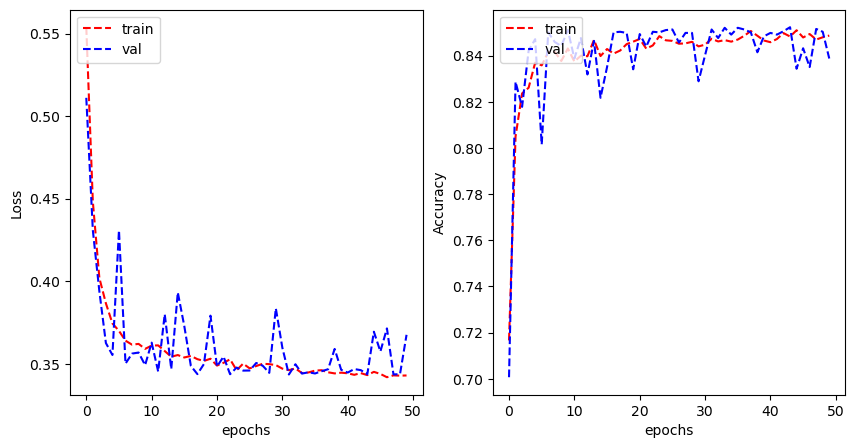

In [12]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [13]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [14]:
model.evaluate(test_generator)

  83/4056 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - categorical_accuracy: 0.8591 - loss: 0.3534 

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4056/4056 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - categorical_accuracy: 0.8437 - loss: 0.3736


[0.3666916787624359, 0.8436883687973022]